# Comparing Estimators for π₀

## Setting the scene

In [1]:
using MultipleTesting

In [2]:
using Distributions
using DataFrames
using Gadfly

In [3]:
srand(42);

## Simulation

We will simulate p-values under the null and alternative hypothesis by drawing from random variable distributions. For the null hypothesis, p-values are uniformly distributed in the interval [0,1]; p-values under the alternative hypothesis are modelled by a Beta distribution with a momotonically decreasing density.

In [4]:
π₀ = 0.7
bum = BetaUniformMixtureModel(π₀, 0.5, 3.0)

MixtureModel{Distributions.Distribution{Distributions.Univariate,Distributions.Continuous}}(K = 2)
components[1] (prior = 0.3000): Distributions.Beta{Float64}(α=0.5, β=3.0)
components[2] (prior = 0.7000): Distributions.Uniform{Float64}(a=0.0, b=1.0)


In [5]:
h₁, h₀ = components(bum);

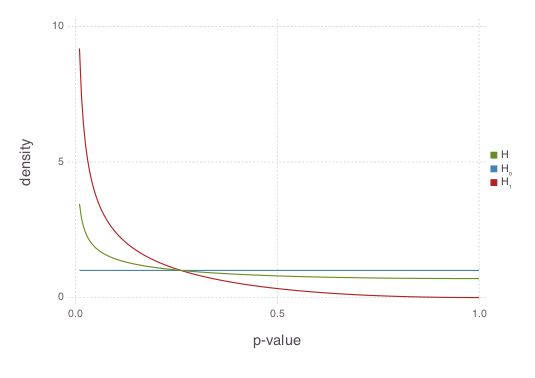

In [6]:
x = linspace(0.01, 1.0, 200);
colors = [colorant"olive drab", colorant"steel blue", colorant"firebrick"]
plot(
    layer(x = x, y = pdf(bum, x), Geom.line, Theme(default_color = colors[1])),
    layer(x = x, y = pdf(h₀, x), Geom.line, Theme(default_color = colors[2])),
    layer(x = x, y = pdf(h₁, x), Geom.line, Theme(default_color = colors[3])),
    Guide.xlabel("p-value"), Guide.ylabel("density"),
    Guide.manual_color_key("", ["H", "H₀", "H₁"], colors)
)

## Assessment of π0 estimators

We assess the performance of three estimators for π0, the fraction of tests under the null hypothesis. Here, we compare different estimators in the package (skipping the Oracle one though, for obvious reasons). Using the mixture model from above, we simulate p-values with a true π0 of 0.7, i.e. 30% of the p-values come from the alternative model.

In [7]:
estimators = filter(x -> x.name.name != :Oracle, subtypes(Pi0Estimator))

8-element Array{Any,1}:
 MultipleTesting.BUM            
 MultipleTesting.CensoredBUM    
 MultipleTesting.FlatGrenander  
 MultipleTesting.LeastSlope     
 MultipleTesting.RightBoundary  
 MultipleTesting.Storey         
 MultipleTesting.StoreyBootstrap
 MultipleTesting.TwoStep        

In [8]:
m = 200;

In [9]:
pi0hat = zeros(m, length(estimators))
for i in 1:m
    pvals = rand(bum, m)
    for (j, e) in enumerate(estimators)
        pi0hat[i,j] = estimate_pi0(pvals, e())
    end
end

In [10]:
df = convert(DataFrame, pi0hat)
names!(df, [e.name.name for e in estimators])
df = stack(df, collect(1:length(estimators)))
names!(df, [:estimator, :π̂₀]);

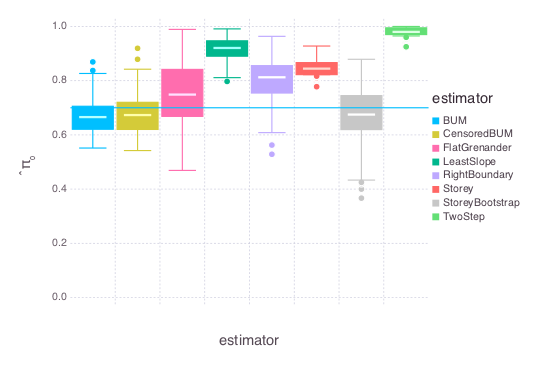

In [11]:
plot(
    layer(yintercept = [π₀], Geom.hline),
    layer(df, x = :estimator, y = :π̂₀, color = :estimator, Geom.boxplot),
    Scale.x_discrete(labels = x -> "")
)

Visualizing the estimated π₀ for the estimators shows us a typical bias-variance tradeoff: For example, Storey's bootstrap has a small bias with regard to the true value (black horizontal line), but exhibits a large degree of variablity. In contrast, the Two Step and the Least Slope estimators have lower variability, while clearly overestimating π₀.